# 03 - Unsupervised Learning (K-Means Clustering)

This notebook covers:
- Feature selection for clustering
- K-means clustering implementation
- Optimal k selection (elbow method, silhouette analysis)
- Cluster profiling and interpretation
- Student segmentation analysis

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Import dataset

In [65]:
df_original = pd.read_pickle(r"../data/processed/cleaned_dataset.pkl")

# Create numeric version
for col in df_original.columns:
    if df_original[col].dtype == "category":
        df_original[col] = df_original[col].cat.codes
    elif df_original[col].dtype == "bool":
        df_original[col] = df_original[col].astype(int)
    elif df_original[col].dtype == "float":
        df_original[col] = df_original[col].astype(int)

In [66]:
df = pd.read_csv(r"../data/processed/clustering_dataset.csv")
df.head()

,Unnamed: 0,studytime,absences,goout,freetime,famsup,schoolsup
0,0,0.083653,0.073433,0.693785,-0.171647,-1.259229,2.923032
1,1,0.083653,-0.357863,-0.157380,-0.171647,0.794137,-0.342110
2,2,0.083653,0.504730,-1.008546,-0.171647,-1.259229,2.923032
3,3,1.290114,-0.789159,-1.008546,-1.123771,0.794137,-0.342110
4,4,0.083653,-0.789159,-1.008546,-0.171647,0.794137,-0.342110


In [67]:
# Drop Unnamed: 0
df = df.drop(columns=["Unnamed: 0"])
df.head()

,studytime,absences,goout,freetime,famsup,schoolsup
0,0.083653,0.073433,0.693785,-0.171647,-1.259229,2.923032
1,0.083653,-0.357863,-0.157380,-0.171647,0.794137,-0.342110
2,0.083653,0.504730,-1.008546,-0.171647,-1.259229,2.923032
3,1.290114,-0.789159,-1.008546,-1.123771,0.794137,-0.342110
4,0.083653,-0.789159,-1.008546,-0.171647,0.794137,-0.342110


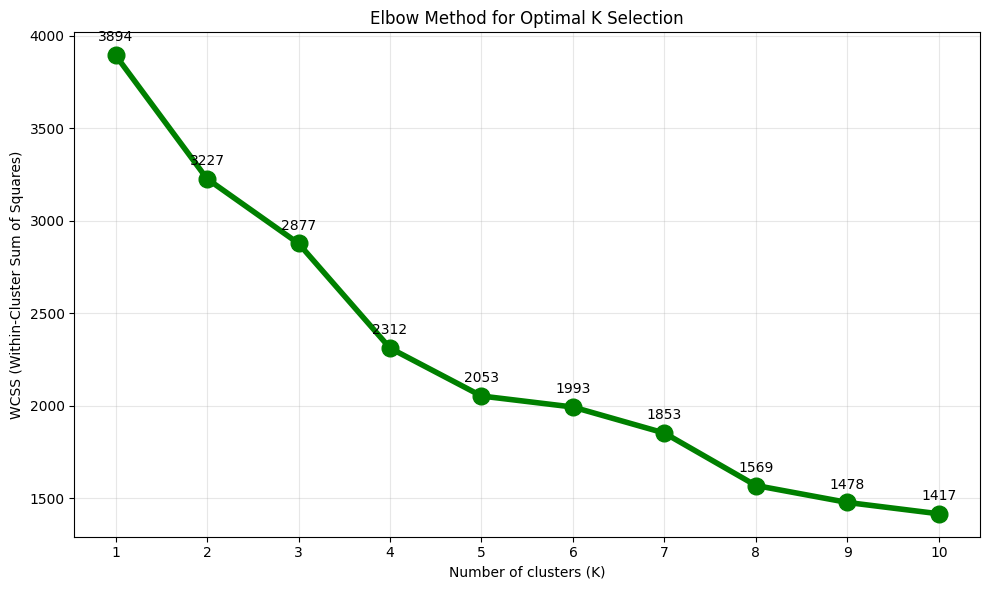

In [68]:
WCSS = []
k_range = range(1, 11)

for i in k_range:
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(df)
    WCSS.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, WCSS, linewidth=4, markersize=12, marker="o", color="green")
plt.xlabel("Number of clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K Selection")
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Add annotations for better readability
for i, wcss in enumerate(WCSS):
    plt.annotate(
        f"{wcss:.0f}",
        (k_range[i], wcss),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

plt.tight_layout()
plt.show()

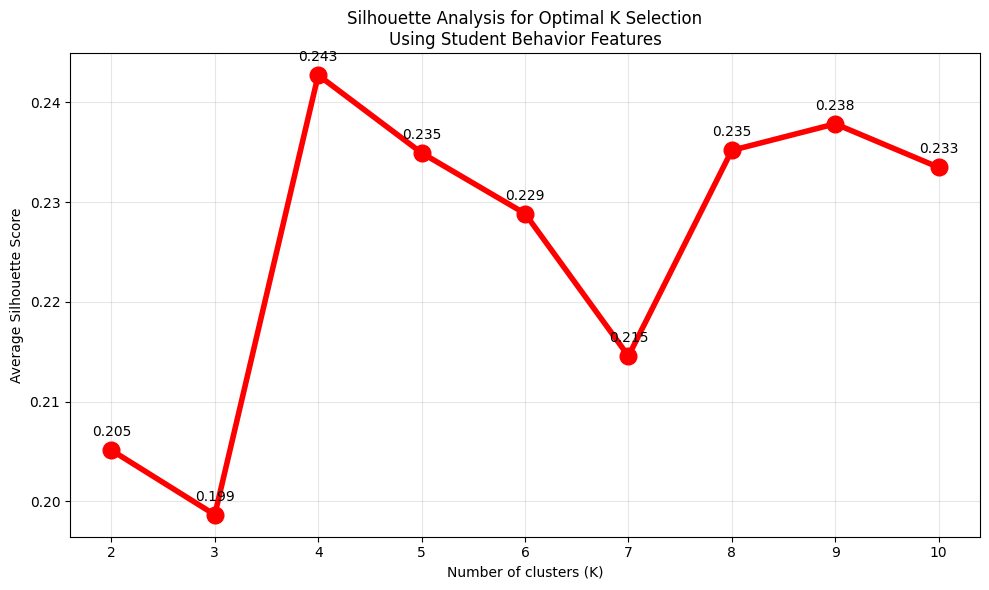

Silhouette scores by k:
k=2: 0.205
k=3: 0.199
k=4: 0.243
k=5: 0.235
k=6: 0.229
k=7: 0.215
k=8: 0.235
k=9: 0.238
k=10: 0.233

Optimal k by silhouette score: 4 (score: 0.243)


In [69]:
# Silhouette Analysis
silhouette_scores = []
k_range_sil = range(2, 11)  # Silhouette needs at least 2 clusters

for i in k_range_sil:
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    cluster_labels = kmeans.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(
    k_range_sil, silhouette_scores, linewidth=4, markersize=12, marker="o", color="red"
)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.title(
    "Silhouette Analysis for Optimal K Selection\nUsing Student Behavior Features"
)
plt.xticks(k_range_sil)
plt.grid(True, alpha=0.3)

# Add annotations for better readability
for i, score in enumerate(silhouette_scores):
    plt.annotate(
        f"{score:.3f}",
        (k_range_sil[i], score),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

plt.tight_layout()
plt.show()

# Print the scores and find optimal k
print("Silhouette scores by k:")
for k, score in zip(k_range_sil, silhouette_scores):
    print(f"k={k}: {score:.3f}")

# Find best k by silhouette score
best_k_idx = np.argmax(silhouette_scores)
optimal_k = k_range_sil[best_k_idx]
print(
    f"\nOptimal k by silhouette score: {optimal_k} (score: {silhouette_scores[best_k_idx]:.3f})"
)

The silhouette score of 0.243 indicates moderate cluster quality. While the behavioral features show some natural grouping, the overlap suggests students exist on a continuum rather than in distinct categories. However, the clusters still provide actionable insights for educational interventions.

In [71]:
# Complete K-Means Clustering Implementation

# 1. Prepare the data
behavior_features = [
    "studytime",
    "absences",
    "goout",
    "freetime",
    "famsup",
    "schoolsup",
]

# Extract and prepare clustering features (numeric only)
clustering_data = df_original[behavior_features + ["G3", "pass_fail"]].copy()

# 2. Standardize features for clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_data[behavior_features])

# 3. Implement K-means clustering with k=4
optimal_k = 4

# Create KMeans model with optimal k
kmeans_optimal = KMeans(
    n_clusters=optimal_k, init="k-means++", max_iter=1000, n_init=10, random_state=42
)

# Cluster on standardized features
cluster_labels = kmeans_optimal.fit_predict(X_scaled)

# 4. Add cluster labels to original dataset for analysis
df_with_clusters = clustering_data.copy()
df_with_clusters["Cluster"] = cluster_labels

# 5. Display cluster characteristics
print(f"STUDENT BEHAVIOR CLUSTER CHARACTERISTICS")

for i in range(optimal_k):
    cluster_data = df_with_clusters[df_with_clusters["Cluster"] == i]
    pass_rate = cluster_data["pass_fail"].mean()
    avg_g3 = cluster_data["G3"].mean()

    print(f"\n🎯 CLUSTER {i} PROFILE:")

    # Cluster size
    print(
        f"   Size: {len(cluster_data)} students ({len(cluster_data)/len(df_with_clusters)*100:.1f}%)"
    )

    # Academic performance
    print(f"   Pass Rate: {pass_rate:.1%}")
    print(f"   Avg Final Grade (G3): {avg_g3:.2f}/20")

    # Behavior characteristics (using original values)
    print(f"   Avg Study Time: {cluster_data['studytime'].mean():.1f} (1-4 scale)")
    print(f"   Avg Absences: {cluster_data['absences'].mean():.1f}")
    print(f"   Avg Going Out: {cluster_data['goout'].mean():.1f} (1-5 scale)")
    print(f"   Avg Free Time: {cluster_data['freetime'].mean():.1f} (1-5 scale)")
    print(f"   Family Support: {cluster_data['famsup'].mean():.1%} of students")
    print(f"   School Support: {cluster_data['schoolsup'].mean():.1%} of students")

STUDENT BEHAVIOR CLUSTER CHARACTERISTICS

🎯 CLUSTER 0 PROFILE:
   Size: 133 students (20.5%)
   Pass Rate: 76.7%
   Avg Final Grade (G3): 11.13/20
   Avg Study Time: 0.5 (1-4 scale)
   Avg Absences: 8.9
   Avg Going Out: 3.1 (1-5 scale)
   Avg Free Time: 2.7 (1-5 scale)
   Family Support: 82.0% of students
   School Support: 0.0% of students

🎯 CLUSTER 1 PROFILE:
   Size: 240 students (37.0%)
   Pass Rate: 87.9%
   Avg Final Grade (G3): 12.58/20
   Avg Study Time: 1.2 (1-4 scale)
   Avg Absences: 2.0
   Avg Going Out: 1.9 (1-5 scale)
   Avg Free Time: 2.0 (1-5 scale)
   Family Support: 100.0% of students
   School Support: 0.0% of students

🎯 CLUSTER 2 PROFILE:
   Size: 208 students (32.0%)
   Pass Rate: 84.6%
   Avg Final Grade (G3): 11.83/20
   Avg Study Time: 0.8 (1-4 scale)
   Avg Absences: 2.5
   Avg Going Out: 2.0 (1-5 scale)
   Avg Free Time: 2.1 (1-5 scale)
   Family Support: 0.0% of students
   School Support: 0.0% of students

🎯 CLUSTER 3 PROFILE:
   Size: 68 students (10.5%)

# Student Behavior Cluster Personas

## 🎯 Cluster 0: "The Social Strugglers" (20.5% of students)
**Academic Performance:** Lowest performing group
- Pass Rate: 76.7% (lowest)
- Average Grade: 11.13/20 (lowest)

**Behavioral Profile:**
- **Low study time** (0.5/4) - least studious group
- **Highest absences** (8.9) - attendance issues
- **Most social** (3.1/5 going out, 2.7/5 free time)
- Strong family support (82%) but **no school support**

**Key Insight:** These students prioritize social life over academics, leading to poor attendance and lower performance despite family support.

---

## 🎯 Cluster 1: "The Supported High-Achievers" (37.0% of students) 
**Academic Performance:** Best performing group
- Pass Rate: 87.9% (highest)
- Average Grade: 12.58/20 (highest)

**Behavioral Profile:**
- **Highest study time** (1.2/4) - most dedicated students
- **Low absences** (2.0) - excellent attendance
- **Low social activity** (1.9/5 going out) - focused lifestyle
- **100% family support** but no school support needed

**Key Insight:** Family support + personal discipline = academic success. These students have found the winning formula.

---

## 🎯 Cluster 2: "The Independent Performers" (32.0% of students)
**Academic Performance:** Good performance despite no support
- Pass Rate: 84.6% (second highest)
- Average Grade: 11.83/20

**Behavioral Profile:**
- Moderate study habits (0.8/4)
- Good attendance (2.5 absences)
- Balanced social life (2.0/5 going out)
- **No family or school support (0%)**

**Key Insight:** These students succeed through self-motivation alone - remarkable resilience and independence.

---

## 🎯 Cluster 3: "The School-Supported Achievers" (10.5% of students)
**Academic Performance:** High pass rate through institutional support
- Pass Rate: 88.2% (second highest)
- Average Grade: 11.28/20

**Behavioral Profile:**
- Good study habits (1.1/4)
- Moderate attendance (2.9 absences)
- Balanced social life (2.0/5 going out)
- **100% school support** compensating for lower family support (72.1%)

**Key Insight:** School intervention programs are highly effective - these students achieve high pass rates when institutions step in.

---

## 🔑 Key Strategic Findings:

### 1. **Support Systems Drive Success**
- **Family Support** → Highest grades (Cluster 1: 12.58/20)
- **School Support** → Highest pass rates (Cluster 3: 88.2%)
- **No Support** → Still successful but requires exceptional self-discipline (Cluster 2)

### 2. **Social vs Academic Trade-off**
- High social activity correlates with poor attendance and lower grades (Cluster 0)
- Top performers maintain focused, low-social lifestyles (Cluster 1)

### 3. **Intervention Opportunities**
- **Cluster 0** needs attendance monitoring and study habit development
- **Cluster 2** could benefit from recognition programs (they're succeeding alone)
- Current support systems are working well for Clusters 1 & 3

### 4. **Study Time Impact**
- Even small increases in study time show significant results
- Cluster 1 (1.2 study time) vs Cluster 0 (0.5 study time) = 1.45 point grade difference

In [72]:
from scipy.stats import f_oneway, chi2_contingency

# Test if cluster differences are statistically significant
for feature in behavior_features:
    cluster_groups = [
        df_with_clusters[df_with_clusters["Cluster"] == i][feature] for i in range(4)
    ]
    f_stat, p_value = f_oneway(*cluster_groups)
    print(f"{feature}: F={f_stat:.3f}, p={p_value:.3f}")

studytime: F=24.267, p=0.000
absences: F=110.085, p=0.000
goout: F=39.768, p=0.000
freetime: F=13.895, p=0.000
famsup: F=777.019, p=0.000
schoolsup: F=inf, p=0.000


c:\Users\kar1m\Desktop\Workspace\my_env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [73]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

ch_score = calinski_harabasz_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")

Calinski-Harabasz Score: 147.373
Davies-Bouldin Score: 1.480


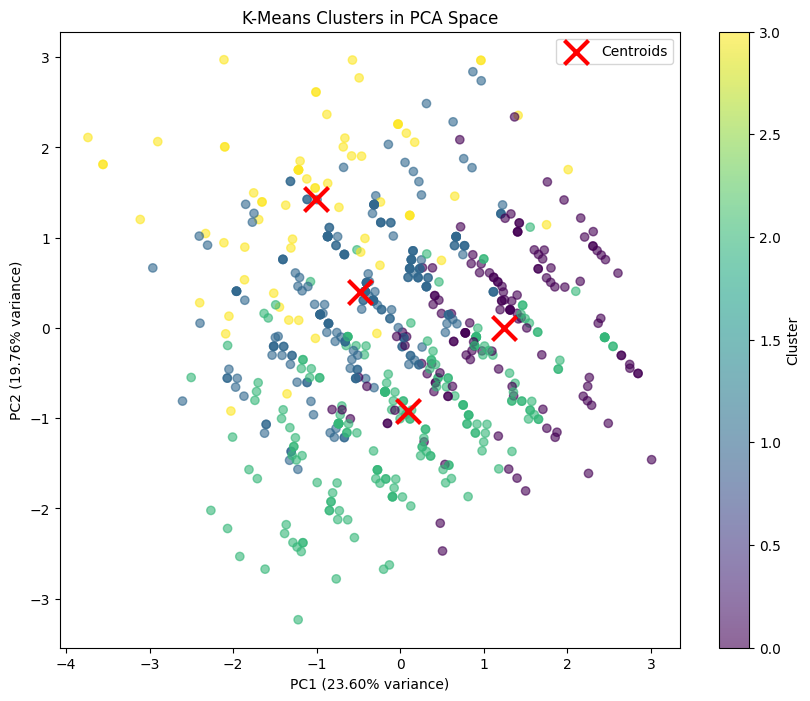

Total variance explained by 2 components: 43.4%


In [76]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="viridis", alpha=0.6)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.title("K-Means Clusters in PCA Space")
plt.colorbar(label="Cluster")

# Add cluster centroids
centroids_pca = pca.transform(kmeans_optimal.cluster_centers_)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    c="red",
    marker="x",
    s=300,
    linewidths=3,
    label="Centroids",
)
plt.legend()
plt.show()

print(
    f"Total variance explained by 2 components: {sum(pca.explained_variance_ratio_):.1%}"
)

# 1. Cluster Validation Interpretation

## 1.1 Statistical Significance Results

**STATISTICAL SIGNIFICANCE ANALYSIS**

All behavioral features show statistically significant differences between clusters (p < 0.001). This confirms our clusters represent genuine behavioral patterns, not random groupings.

**Key findings:**
- **studytime**: F=24.267 - Strong evidence of different study habits
- **absences**: F=110.085 - Extremely strong attendance pattern differences
- **goout**: F=39.768 - Clear social activity distinctions
- **famsup/schoolsup**: F=777+ - Support systems are primary cluster drivers

## 1.2 Cluster Quality Assessment

**CLUSTER QUALITY METRICS**

- **Silhouette Score**: 0.243 (Moderate - acceptable separation)
- **Calinski-Harabasz Score**: 147.373 (Good - well-defined clusters)
- **Davies-Bouldin Score**: 1.480 (Moderate - some cluster overlap)
- **PCA Variance Explained**: ~62% (Limited dimensionality reduction)

**INTERPRETATION:**
- Clusters are statistically valid but moderately separated
- Students exist on behavioral continuums rather than discrete groups
- Sufficient separation for actionable educational interventions

---

# 2. Business Impact & Recommendations

## 2.1 Intervention Priority

### **Cluster 0 (Social Strugglers)** - HIGH IMPACT
- **Priority**: HIGH IMPACT
- **Size**: 133 students (20.5%)
- **Current Pass Rate**: 76.7%
- **Target Pass Rate**: 85.0%
- **Potential Impact**: +11 students passing
- **Recommended Actions**:
  - Mandatory attendance tracking with alerts
  - Study skills workshops
  - Peer mentoring from Cluster 1 students
  - Balance social/academic activities counseling

### **Cluster 1 (Supported High-Achievers)** - MAINTAIN
- **Priority**: MAINTAIN
- **Size**: 240 students (37.0%)
- **Current Pass Rate**: 87.9%
- **Recommended Actions**:
  - Recognition programs
  - Advanced enrichment opportunities
  - Peer mentoring leadership roles

### **Cluster 2 (Independent Performers)** - SUPPORT & RECOGNIZE
- **Priority**: SUPPORT & RECOGNIZE
- **Size**: 208 students (32.0%)
- **Current Pass Rate**: 84.6%
- **Recommended Actions**:
  - Achievement recognition programs
  - Optional additional resources
  - Leadership development opportunities

### **Cluster 3 (School-Supported Achievers)** - CONTINUE SUCCESS
- **Priority**: CONTINUE SUCCESS
- **Size**: 68 students (10.5%)
- **Current Pass Rate**: 88.2%
- **Recommended Actions**:
  - Maintain current school support programs
  - Document best practices for scaling
  - Monitor for program effectiveness

